# TODO

TODO: description

In [1]:
import math
import torch
import numpy as np
import gpytorch
from matplotlib import pyplot as plt


In [2]:
## create synthetic dataset as shown in original GPC paper
## https://github.com/dmilios/dirichletGPC/blob/master/run_dirichletGP_example.py
## ===============================


N = 20  # training data
np.random.seed(1235)

xmax = 15
X = np.random.rand(N,1) * xmax
Xtest = np.linspace(0, xmax*1.5, 200).reshape(-1, 1)
Z = X.copy()

y = np.cos(X.flatten()) / 2 + 0.5
y = np.random.rand(y.size) > y
y = y.astype(int)
if np.sum(y==1) == 0:
    y[0] = 1
elif np.sum(y==0) == 0:
    y[0] = 0

# one-hot vector encoding
Y01 = np.zeros((y.size, 2))
Y01[:,0], Y01[:,1] = 1-y, y


### latent log process
a_eps=0.1
s2_tilde = np.log(1.0/(Y01+a_eps) + 1)
Y_tilde = np.log(Y01+a_eps) - 0.5 * s2_tilde


# For each y, we have two possibilities: 0+alpha and 1+alpha
# Changing alpha (the scale of Gamma) changes the distance
# between different class instances.
# Changing beta (the rate of Gamma) changes the position 
# (i.e. log(alpha)-log(beta)-s2_tilde/2 ) but NOT the distance.
# Thus, we can simply move y for all classes to our convenience (ie zero mean)

# 1st term: guarantees that the prior class probabilities are correct
# 2nd term: just makes the latent processes zero-mean
#ymean = np.log(Y01.mean(0)) + np.mean(Y_tilde-np.log(Y01.mean(0)))
#Y_tilde = Y_tilde - ymean

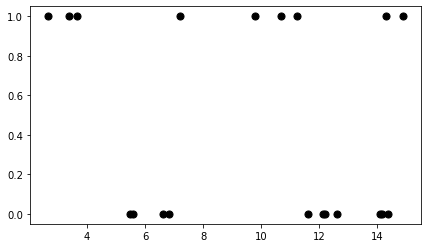

In [3]:
## plot samples

fig, ax = plt.subplots(1, 1, figsize=(7, 4))

ax.scatter(X, y, s=50, color="k")

plt.show();

In [4]:
## build GPC model using GPyTorch

from gpytorch.models import ExactGP
from gpytorch.likelihoods import DirichletClassificationLikelihood
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, RBFKernel

num_classes = 2
train_x = torch.tensor(X).float()
train_y = torch.tensor(y)
test_x = torch.tensor(np.linspace(0-5, xmax+5, 100)).float()

In [7]:
# We will use the simplest form of GP model, exact inference
class DirichletGPModel(ExactGP):
    def __init__(self, train_x, train_y, likelihood, num_classes):
        super(DirichletGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean(batch_shape=torch.Size((num_classes,)))
        self.covar_module = ScaleKernel(
            RBFKernel(batch_shape=torch.Size((num_classes,))),
            batch_shape=torch.Size((num_classes,)),
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
# we let the DirichletClassificationLikelihood compute the targets for us
likelihood = DirichletClassificationLikelihood(train_y, learn_additional_noise=True)
model = DirichletGPModel(train_x, likelihood.transformed_targets, likelihood, num_classes=likelihood.num_classes)

In [8]:
# this is for running the notebook in our testing framework
training_iter = 50


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, likelihood.transformed_targets).sum()
    loss.backward()
    if i % 5 == 0:
        print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
            i + 1, training_iter, loss.item(),
            model.covar_module.base_kernel.lengthscale.mean().item(),
            model.likelihood.second_noise_covar.noise.mean().item()
        ))
    optimizer.step()

Iter 1/50 - Loss: 6.572   lengthscale: 0.693   noise: 0.693
Iter 6/50 - Loss: 5.943   lengthscale: 0.968   noise: 0.973
Iter 11/50 - Loss: 5.597   lengthscale: 1.230   noise: 1.303
Iter 16/50 - Loss: 5.405   lengthscale: 1.329   noise: 1.670
Iter 21/50 - Loss: 5.272   lengthscale: 1.249   noise: 2.047
Iter 26/50 - Loss: 5.181   lengthscale: 1.092   noise: 2.394
Iter 31/50 - Loss: 5.128   lengthscale: 0.946   noise: 2.681
Iter 36/50 - Loss: 5.098   lengthscale: 0.848   noise: 2.893
Iter 41/50 - Loss: 5.080   lengthscale: 0.802   noise: 3.033
Iter 46/50 - Loss: 5.068   lengthscale: 0.796   noise: 3.111


In [ ]:
model.eval()
likelihood.eval()

with gpytorch.settings.fast_pred_var(), torch.no_grad():
    test_dist = model(test_x)
    pred_means = test_dist.loc
    
pred_samples = test_dist.sample(torch.Size((256,)))
pred_samples_exp = pred_samples.exp()
pred_samples_mean = pred_samples.mean(0)
pred_samples_lb = np.percentile(pred_samples[:,1,:].numpy(), 2.5, axis=0)
pred_samples_ub = np.percentile(pred_samples[:,1,:].numpy(), 97.5, axis=0)

#probs
pred_samples_norm = (pred_samples_exp / pred_samples_exp.sum(-2, keepdim=True))
probabilities = pred_samples_norm.mean(0)
pred_samples_prob_lb = np.percentile(pred_samples_norm[:,1,:].numpy(), 2.5, axis=0)
pred_samples_prob_ub = np.percentile(pred_samples_norm[:,1,:].numpy(), 97.5, axis=0)
#print(pred_samples_lb)

In [ ]:
## plot samples

# fix y_tilde to have the right height (it doesn't matter for the probabilities)
y_tilde_plot = Y_tilde[:,1] - (Y_tilde[:,1].max() - pred_samples_mean[1].max()).item()

fig, ax = plt.subplots(1, 2, figsize=(15, 3))

ax[0].scatter(X, y_tilde_plot, s=50, color="k")
ax[0].plot(test_x, pred_samples_mean[1], color="orange")
ax[0].fill_between(test_x, pred_samples_ub, pred_samples_lb, alpha=0.2)


ax[1].scatter(X, y, s=50, color="k")
ax[1].plot(test_x, probabilities[1].numpy(), color="orange")
#ax.scatter(test_x, pred_samples_norm[:,0,:], alpha=0.1)
ax[1].fill_between(test_x, pred_samples_prob_ub, pred_samples_prob_lb, alpha=0.2)

plt.show();

# Now use LM for Beta for the same task

In [ ]:
# define LM for Beta and apply to datapoints

def LB_beta(alpha, beta):
    
    mu = np.log(alpha/beta)
    var = (alpha+beta)/(alpha*beta)
    return(mu, var)

In [ ]:
eps_alpha = 0.1
eps_beta = 0.1

train_alphas = torch.ones_like(train_y) * eps_alpha
train_alphas[train_y > 0.5] += 1
train_betas = torch.ones_like(train_y) * eps_beta
train_betas[train_y < 0.5] += 1

train_mu_LB, train_var_LB = LB_beta(train_alphas, train_betas)
print(train_mu_LB)

In [ ]:
# create GP for the now Gaussian datapoints

# We will use the simplest form of GP model, exact inference
class LBGPModel(ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(LBGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
#likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_covar=torch.sqrt(train_var_LB))#, learn_additional_noise=False)
likelihood = gpytorch.likelihoods.FixedNoiseGaussianLikelihood(noise=torch.sqrt(train_var_LB))#, learn_additional_noise=False)
model = LBGPModel(train_x, train_mu_LB, likelihood)

In [ ]:
# predict

# this is for running the notebook in our testing framework
training_iter = 50

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x.view(-1,1))
    # Calc loss and backprop gradients
    loss = -mll(output, train_mu_LB)
    loss.backward()
    #print(model.covar_module.base_kernel.kernels[0])
    """
    if i % 5 == 0:
        print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
            i + 1, training_iter, loss.item(),
            model.covar_module.base_kernel.lengthscale.item(),
            model.likelihood.noise.item()
        ))
    """
    if i % 5 == 0:
        print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f'% (
            i + 1, training_iter, loss.item(),
            model.covar_module.base_kernel.lengthscale.item()
        ))
    optimizer.step()

In [ ]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(test_x))

In [ ]:
def logistic(x):
    return(1 / (1 + np.exp(-x)))

pred_mean = observed_pred.mean.numpy()
pred_mean_logistic = logistic(pred_mean)
lb_pred, ub_pred = observed_pred.confidence_region()
lb_pred_logistic, ub_pred_logistic = logistic(lb_pred), logistic(ub_pred)

#print(lb_pred_logistic)

In [ ]:
# update plot to contain GPC and LM(Beta)+GP

## plot samples

# fix y_tilde to have the right height (it doesn't matter for the probabilities)
y_tilde_plot = Y_tilde[:,1] - (Y_tilde[:,1].max() - pred_samples_mean[1].max()).item()

fig, ax = plt.subplots(2, 2, figsize=(15, 7))

ax[0][0].scatter(X, y_tilde_plot, s=50, color="k")
ax[0][0].plot(test_x, pred_samples_mean[1], color="orange")
ax[0][0].fill_between(test_x, pred_samples_ub, pred_samples_lb, alpha=0.2)

ax[0][1].scatter(X, y, s=50, color="k")
ax[0][1].plot(test_x, probabilities[1].numpy(), color="orange")
ax[0][1].fill_between(test_x, pred_samples_prob_ub, pred_samples_prob_lb, alpha=0.2)


# LB beta
ax[1][0].scatter(X, train_mu_LB, s=50, color="k")
ax[1][0].plot(test_x, pred_mean, color="firebrick")
ax[1][0].fill_between(test_x, lb_pred, ub_pred, alpha=0.2, color="cornflowerblue")

ax[1][1].scatter(X, y, s=50, color="k")
ax[1][1].plot(test_x, pred_mean_logistic, color="firebrick")
ax[1][1].fill_between(test_x, lb_pred_logistic, ub_pred_logistic, alpha=0.2, color="cornflowerblue")

plt.show();

# Using conjugate property to summarize inputs - inducing points

In [ ]:
## create synthetic dataset as shown in original GPC paper
## https://github.com/dmilios/dirichletGPC/blob/master/run_dirichletGP_example.py
## ===============================


N = 200  # training data
np.random.seed(1235)

xmax = 15
X_ = np.random.rand(N,1) * xmax
Xtest_ = np.linspace(0, xmax*1.5, 200).reshape(-1, 1)
Z_ = X_.copy()

y_ = np.cos(X_.flatten()) / 2 + 0.5
y_ = np.random.rand(y_.size) > y_
y_ = y_.astype(int)
if np.sum(y_==1) == 0:
    y_[0] = 1
elif np.sum(y_==0) == 0:
    y_[0] = 0
    
## plot samples
fig, ax = plt.subplots(1, 1, figsize=(7, 4))

ax.scatter(X_, y_, s=50, color="k")
for i in range(16):
    ax.axvline(x=i, linestyle="--", color="purple")

plt.show();

In [ ]:
# create pseudo points with conjugate property of the beta

eps_alpha = 0.1
eps_beta = 0.1
X_ = torch.tensor(X_).view(-1)

x_collected = torch.arange(15) + 0.5
train_alphas_collected = torch.ones_like(x_collected) * eps_alpha
train_betas_collected = torch.ones_like(x_collected) * eps_beta


for i in range(15):
    y_selected = torch.tensor(y_[torch.logical_and(X_ > i, X_ < i+1)])
    ones = torch.sum(y_selected)
    zeros = len(y_selected) - ones
    train_alphas_collected[i] += ones
    train_betas_collected[i] += zeros
    
print(train_alphas_collected)
print(train_betas_collected)


train_mu_LB_collected, train_var_LB_collected = LB_beta(train_alphas_collected, train_betas_collected)
print(train_mu_LB_collected)

In [ ]:
# create GP for the now Gaussian datapoints

# We will use the simplest form of GP model, exact inference
class LBGPModel2(ExactGP):
    def __init__(self, c_collected, train_y, likelihood):
        super(LBGPModel2, self).__init__(x_collected, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
#likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_covar=torch.sqrt(train_var_LB))
likelihood = gpytorch.likelihoods.FixedNoiseGaussianLikelihood(noise=torch.sqrt(train_var_LB_collected))
model = LBGPModel2(x_collected, train_mu_LB_collected, likelihood)

In [ ]:
# predict

# this is for running the notebook in our testing framework
training_iter = 50

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(x_collected.view(-1,1))
    # Calc loss and backprop gradients
    loss = -mll(output, train_mu_LB_collected)
    loss.backward()
    #print(model.covar_module.base_kernel.kernels[0])
    """
    if i % 5 == 0:
        print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
            i + 1, training_iter, loss.item(),
            model.covar_module.base_kernel.lengthscale.item(),
            model.likelihood.noise.item()
        ))
    """
    if i % 5 == 0:
        print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f'% (
            i + 1, training_iter, loss.item(),
            model.covar_module.base_kernel.lengthscale.item()
        ))
    optimizer.step()

In [ ]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_dist = model(test_x)
    observed_pred_collected = likelihood(test_dist)
    
pred_samples = test_dist.sample(torch.Size((10000,)))

In [ ]:
pred_mean_collected = observed_pred_collected.mean.numpy()
pred_mean_collected_logistic = logistic(pred_mean_collected)
lb_pred_collected, ub_pred_collected = observed_pred_collected.confidence_region()
lb_pred_collected_logistic, ub_pred_collected_logistic = logistic(lb_pred_collected), logistic(ub_pred_collected)

In [ ]:
# update plot to contain GPC and LM(Beta)+GP

## plot samples

# fix y_tilde to have the right height (it doesn't matter for the probabilities)
y_tilde_plot = Y_tilde[:,1] - (Y_tilde[:,1].max() - pred_samples_mean[1].max()).item()

fig, ax = plt.subplots(3, 2, figsize=(15, 10))

ax[0][0].scatter(X, y_tilde_plot, s=50, color="k")
ax[0][0].plot(test_x, pred_samples_mean[1], color="orange")
ax[0][0].fill_between(test_x, pred_samples_ub, pred_samples_lb, alpha=0.2)

ax[0][1].scatter(X, y, s=50, color="k")
ax[0][1].plot(test_x, probabilities[1].numpy(), color="orange")
ax[0][1].fill_between(test_x, pred_samples_prob_ub, pred_samples_prob_lb, alpha=0.2)


# LB beta
ax[1][0].scatter(X, train_mu_LB, s=50, color="k")
ax[1][0].plot(test_x, pred_mean, color="firebrick")
ax[1][0].fill_between(test_x, lb_pred, ub_pred, alpha=0.2, color="cornflowerblue")

ax[1][1].scatter(X, y, s=50, color="k")
ax[1][1].plot(test_x, pred_mean_logistic, color="firebrick")
ax[1][1].fill_between(test_x, lb_pred_logistic, ub_pred_logistic, alpha=0.2, color="cornflowerblue")


# LB beta with many more points + conjugate inducing idea
for i in range(16):
    ax[2][0].axvline(x=i, linestyle="--", color="navy")
ax[2][0].scatter(x_collected, train_mu_LB_collected, s=100, color="green")
ax[2][0].plot(test_x, pred_mean_collected, color="firebrick")
ax[2][0].fill_between(test_x, lb_pred_collected, ub_pred_collected, alpha=0.2, color="cornflowerblue")


for i in range(16):
    ax[2][1].axvline(x=i, linestyle="--", color="navy")
ax[2][1].scatter(X_, y_, s=50, color="k")
ax[2][1].scatter(x_collected, logistic(train_mu_LB_collected), s=100, color="forestgreen")
ax[2][1].plot(test_x, pred_mean_collected_logistic, color="firebrick")
ax[2][1].fill_between(test_x, lb_pred_collected_logistic, ub_pred_collected_logistic, alpha=0.2, color="cornflowerblue")


plt.tight_layout()
plt.show();

In [ ]:
# choose samples in block between 1 and 2
logistic(pred_samples).size()

# value -5 is at pos 0 in array, 0 is at 20, 1 is at 24, 2 is at 28 and 1.5 is at 26
marginal_GP_samples_24 = logistic(pred_samples[:,24]).view(-1).numpy()
marginal_GP_samples_25 = logistic(pred_samples[:,25]).view(-1).numpy()
marginal_GP_samples_26 = logistic(pred_samples[:,26]).view(-1).numpy()
marginal_GP_samples_27 = logistic(pred_samples[:,27]).view(-1).numpy()
#print(marginal_GP_samples)

In [ ]:
# plot one of the marginals for the Beta distributions

a1 = train_alphas_collected[1]
b1 = train_betas_collected[1]
print(a1, b1)

x_01 = np.linspace(0, 1, 1001)
eps1 = np.random.random(9)
eps1 = (eps1 - eps1.mean())/10 + 0.03
print(eps1)

eps2 = np.random.random(5)
eps2 = (eps2 - eps2.mean())/10 + 0.97
print(eps2)

from scipy.stats import beta

beta_pdf = beta.pdf(x_01, a1, b1)

fig, ax = plt.subplots(1,1, figsize=(10, 5), dpi=200)
ax.plot(x_01, beta_pdf, label="marginal Beta between 1 and 2", linewidth=3)

for i in range(len(eps1)):
    ax.axvline(eps1[i], 0, 0.3, color="k")
    
for i in range(len(eps2)):
    ax.axvline(eps2[i], 0, 0.3, color="k")
    
ax.axvline(eps1[0], 0, 0.3, color="k", label="data points between 1 and 2")
ax.hist(marginal_GP_samples_24, density=True, bins=50, color="orange", alpha=0.3, label="marginal GP prediction at 1.0")
ax.hist(marginal_GP_samples_25, density=True, bins=50, color="green", alpha=0.3, label="marginal GP prediction at 1.25")
ax.hist(marginal_GP_samples_26, density=True, bins=50, color="red", alpha=0.3, label="marginal GP prediction at 1.5")
#ax.hist(marginal_GP_samples_27, density=True, bins=50, color="cyan", alpha=0.3, label="marginal GP prediction at 1.75")
    
ax.set_yticks([])
ax.legend()

plt.show();